In [1]:
from helpers import *

In [2]:
# plot a pretty picture in the current directory called "output.png"
simulator = mendelSim(precision = 50, num_points=100000)
simulator.run_sim()

1.5882573

In [3]:
# parallelize to speed up
def monteCarlo(precision, num_points, simStrat):
    # no plot simulator
    simulator = mendelSim(precision=precision, num_points=num_points, simStrat = simStrat, draw=False, niceColors=False)
    return simulator.run_sim()

In [4]:
# try to get a good estimate of the influence of num_points (s) and precision(i)
# alter amount of jobs to fit your system
# results for precision
# shuffle the input to enhance time estimate
inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = i, num_points = 30000)
                                      for i in notebook.tqdm(inputPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
# results for number of points
inputPointSize = 10000
inputPoints = np.arange(inputPointSize)
np.random.shuffle(inputPoints)
resultsPoints = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = 30, num_points = i+1) for i in notebook.tqdm(inputPoints))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
# investigate the convergence of the two parameters
# convert to np array to enhance speed

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))


arrPoints = np.array(resultsPoints)
errorPoints = abs(arrPoints - arrPoints[np.where(inputPoints == inputPointSize-1)[0]])
pointResult = np.array((inputPoints, arrPoints, errorPoints))


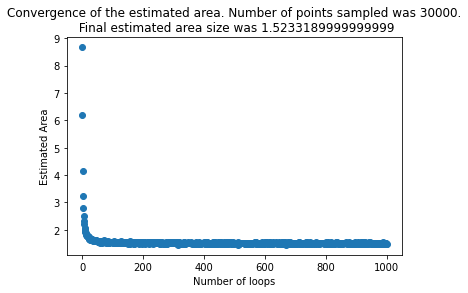

In [7]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was 30000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionArea.jpg")

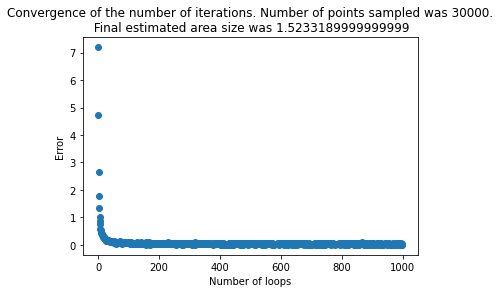

In [8]:
plt.scatter(precisionResult[0], precisionResult[2])
plt.ylabel("Error")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the number of iterations. Number of points sampled was 30000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionConvergence.jpg")

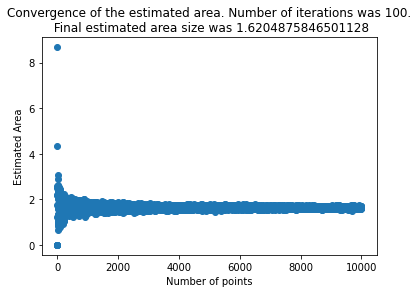

In [9]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 100.\n Final estimated area size was {arrPoints[-1]}")
plt.savefig("pointsArea.jpg")

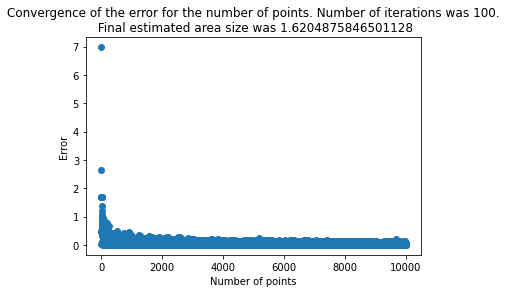

In [10]:
plt.scatter(pointResult[0], pointResult[2])
plt.ylabel("Error")
plt.xlabel("Number of points")
plt.title(f"Convergence of the error for the number of points. Number of iterations was 100.\n Final estimated area size was {arrPoints[-1]}")
plt.savefig("pointsArea.jpg")

In [11]:
simulator = mendelSim(simStrat = "latin", width = 1000, aspectRatio = 1, precision = 100)
simulator.run_sim()

1.3756399999999998

In [12]:
def monteCarloLatin(precision, width):
    simulator = mendelSim(simStrat = "latin", width = width, aspectRatio = 1, precision = precision, draw=False, niceColors=False)
    return simulator.run_sim()


In [13]:
#test convergence of latin hypercube strategy. This works a little differently, because our input points are dependent on the 
# width of the picture

inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = i, width = 10000)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

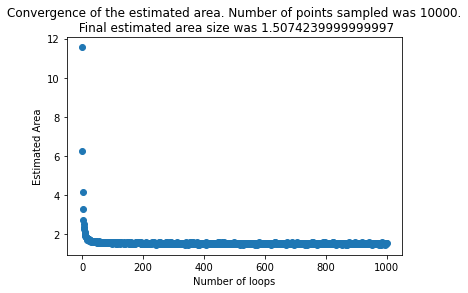

In [14]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was 10000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionAreaLatin.jpg")

In [15]:
inputPointSize = 10000
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = 60, width = i+1)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
errorPoint = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)][0])
pointResult = np.array((inputPoint, arrPoint, errorPoint))

  0%|          | 0/10000 [00:00<?, ?it/s]

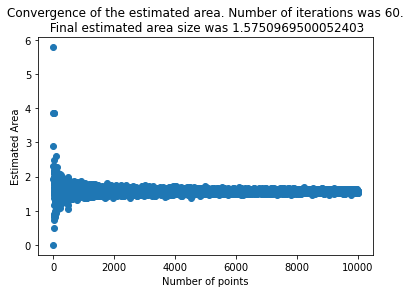

In [16]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 60.\n Final estimated area size was {arrPoint[-1]}")
plt.savefig("pointsAreaLatin.jpg")